Learning How Reverse Mode Auto Differentiation Works

In [199]:
class Value():
    def __init__(self, data, parents=(), op='', label=''): 
        self.data = data
        self.parents = parents
        self.grad = 0
        self.op = op
        self.label = label
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")    
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

    def __repr__(self): 
        return f"Value(data: {self.data}, label: {self.label})"

    def backward(self):
        for i, parent in enumerate(self.parents):
            if self.op == "*":
                parent.grad = self.parents[~i].data * self.grad
            elif self.op == "+":
                # addition simply propogates our gradients to parents
                parent.grad = 1 * self.grad

    def backpropogate(self):
        self.grad = 1

        def _backpropogate(value):
            value.backward()
            for parent in value.parents:
                _backpropogate(parent)
                    
        _backpropogate(self)

In [204]:
a = Value(3.0) 
a.label = "a"
b = Value(5.0)
b.label = "b"
c = Value(6.0)
c.label = "c"


e = c * d
e.label = "e"
f = Value(2.0)
f.label = "f"

l = e * f 
l.label = "loss"


g = l * Value(3.0, label="z")
g.label = "g"
h = g * Value(2.0, label="y")
h.label = "h"
i = h + Value(1.0, label="x")
i.label = "i"

In [205]:
import graphviz 

def mapviz(root, dot):
    dot.node(root.label, f"{root.label} | {root.data} | {root.grad}") 
    
    if (root.op):
        dot.node(root.label + root.op, root.op)
        dot.edge(root.label, root.label + root.op)

    for parent in root.parents:
        dot.node(parent.label, f"{parent.label} | {parent.data} | {parent.grad}")
        dot.edge(root.label + root.op, parent.label)
        mapviz(parent, dot)


In [179]:
# l = e*f
# dl/dl = 1
# dl/de = f = 2.0 
# dl/df = e = 48.0
# dl/dc = dl/de * de/dc = e.grad * d.data = 2.0 * 8 = 16
# dl/dd = dl/de * de/dd = e.grad * c.data = 2.0 * 6 = 12
# dl/da = dl/dd * dd/da = d.grad * b.data = 12 * 1 = 12
# dl/db = dl/dd * dd/db = d.grad * a.data = 12 * 1 = 12

# l.grad = 1.0
# e.grad = 2.0
# f.grad = 48.0
# c.grad = 384
# d.grad = 288
# a.grad = 288
# b.grad = 288

# l.grad = 1
# l.backward()
# e.backward()
# d.backward()


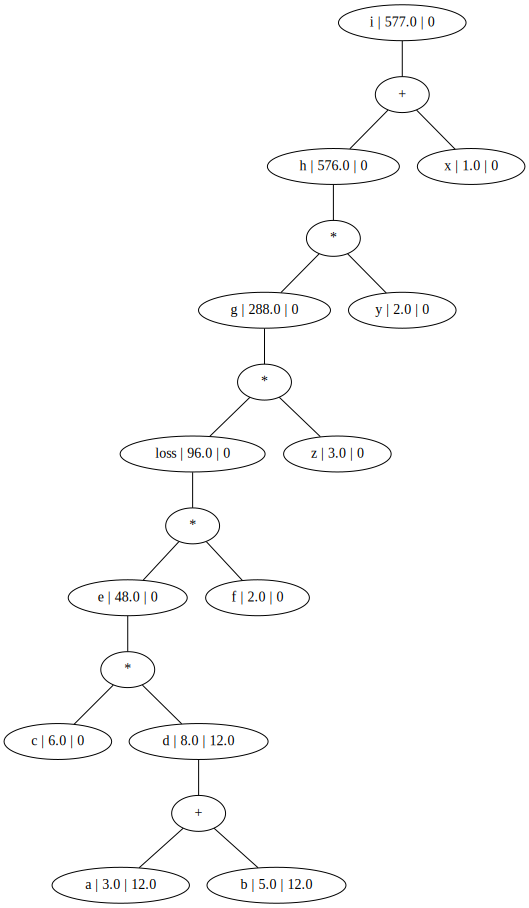

In [206]:
# backpropogate(l)
i.backpropogate()

graph = graphviz.Graph('back prop') 
mapviz(i, graph)
graph